# Tasmanian El nino climatology

Looking at ACORN-SAT temperature data for December across El nino years at three Tasmanian weather stations: Launceston Airport, Butlers Gorge and Hobart.

References
* The list of El nino years from [El Nino climate patterns](http://www.bom.gov.au/climate/enso/ninocomp.shtml)
* ACORN-SAT data for 3 Tasmanian stations from [Long term temperature record](http://www.bom.gov.au/climate/change/acorn-sat/#tabs=Data-and-networks)

In [149]:
%matplotlib inline
from pandas import *
import calendar
import datetime

EL_NINO_YEARS = [1905,1914,1940,1941,1946,1965,1972,1977,1982,1991,1994,1997]
MONTH = 12

#calendar.monthrange(2002,1)

LAUNCESTON = {'stn_num': 91311, 'name': 'Launceston Airport'}
BUTLERS_GORGE = {'stn_num': 96003, 'name': 'Butlers Gorge'}
HOBART = {'stn_num': 94029, 'name': 'Hobart'}

LOCATIONS = [LAUNCESTON, BUTLERS_GORGE, HOBART]

DATE_HEADING = 'date'
MIN_T_HEADING = 'minT'
MAX_T_HEADING = 'maxT'
DIURNAL_RANGE_HEADING = 'range'
STATION_NUMBER_HEADING = 'stn_num'
WX = [MIN_T_HEADING,MAX_T_HEADING]

def get_formatted_stn_num(stn_num):
    return str(stn_num).zfill(6)

def get_ACORN_SAT_URL(stn_num,wx='maxT'):
    return "http://www.bom.gov.au/climate/change/acorn/sat/data/acorn.sat.{wx}.{stn_num}.daily.txt".format(wx=wx,stn_num=stn_num)

def get_ACORN_SAT_DATA(stn_num, wx=WX):
    data = None
    for w in wx:
        url = get_ACORN_SAT_URL(stn_num,w)
        temp = read_table(
            url, 
            header=None, 
            sep="\s*", # some amount of whitespace
            skiprows=1, 
            engine="python", # required to use regex in sep
            index_col=False,
            na_values=99999.9,
            names=[DATE_HEADING,w]) # no header supplied
        if data is None: data = temp
        else: data = merge(data, temp, on=DATE_HEADING, how="inner")
    data[DATE_HEADING] = to_datetime(data[DATE_HEADING],format="%Y%m%d")
    #data.index = data[DATE_HEADING]
    if MIN_T_HEADING in wx and MAX_T_HEADING in wx:
        data[DIURNAL_RANGE_HEADING] = data[MAX_T_HEADING] - data[MIN_T_HEADING]
    return data #data[data.columns[1:]] ## date column is index

In [150]:
data = None
for loc in LOCATIONS:
    stn_num = get_formatted_stn_num( loc['stn_num'] )
    temp = get_ACORN_SAT_DATA(stn_num)
    temp[STATION_NUMBER_HEADING] = stn_num
    if data is None: data = temp
    else: data = data.append(temp)
data.reset_index(inplace=True, drop=True)

In [151]:
data.head()

,date,minT,maxT,range,stn_num
0,1910-01-01,3.4,24.0,20.6,091311
1,1910-01-02,5.7,30.3,24.6,091311
2,1910-01-03,10.4,32.2,21.8,091311
3,1910-01-04,10.6,24.0,13.4,091311
4,1910-01-05,6.6,25.1,18.5,091311


In [152]:
dateColumn = data[DATE_HEADING]
dateColumn.head()

0   1910-01-01
1   1910-01-02
2   1910-01-03
3   1910-01-04
4   1910-01-05
Name: date, dtype: datetime64[ns]

In [153]:
## subset to only El nino years
def is_el_nino_year(year):
    return (year in EL_NINO_YEARS)
data = data[data[DATE_HEADING].dt.year.apply(is_el_nino_year)]
data.head()

,date,minT,maxT,range,stn_num
1461,1914-01-01,3.4,20.0,16.6,091311
1462,1914-01-02,10.6,19.7,9.1,091311
1463,1914-01-03,2.0,19.5,17.5,091311
1464,1914-01-04,6.6,20.9,14.3,091311
1465,1914-01-05,5.7,20.0,14.3,091311


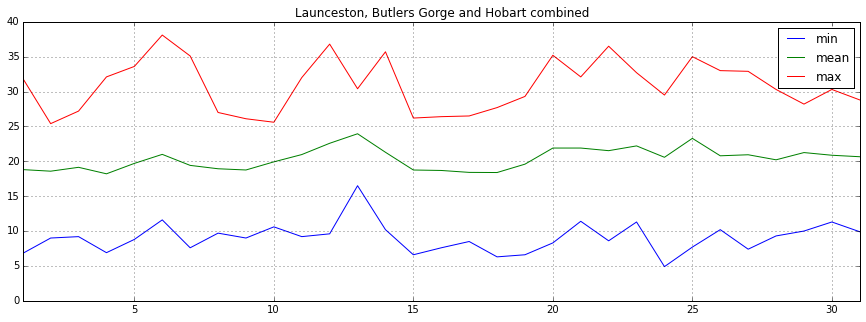

In [158]:
## subset to only MONTH
data = data[data[DATE_HEADING].dt.month == MONTH]
import numpy as np
december = DataFrame()
december['min'] = data.groupby(data[DATE_HEADING].dt.day)[MAX_T_HEADING].aggregate(np.min)
december['mean'] = data.groupby(data[DATE_HEADING].dt.day)[MAX_T_HEADING].aggregate(np.mean)
december['max'] = data.groupby(data[DATE_HEADING].dt.day)[MAX_T_HEADING].aggregate(max)
december.head()
december.plot(figsize=(15,5),grid=True, title='Launceston, Butlers Gorge and Hobart combined')

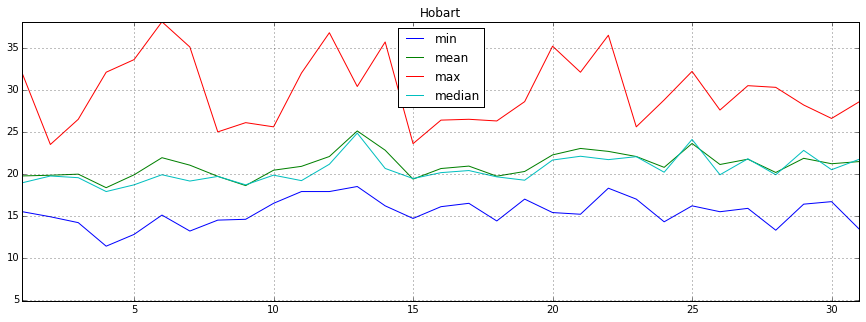

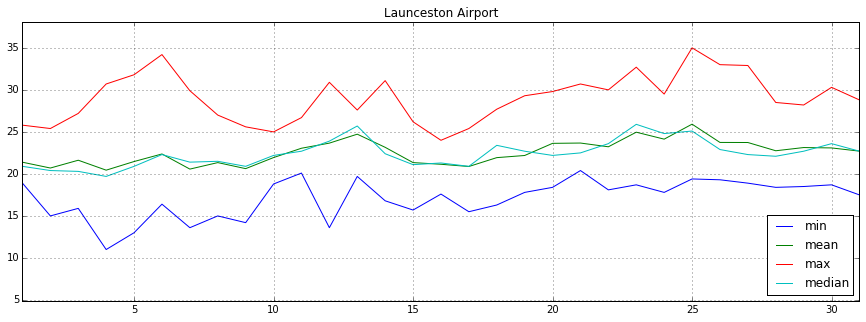

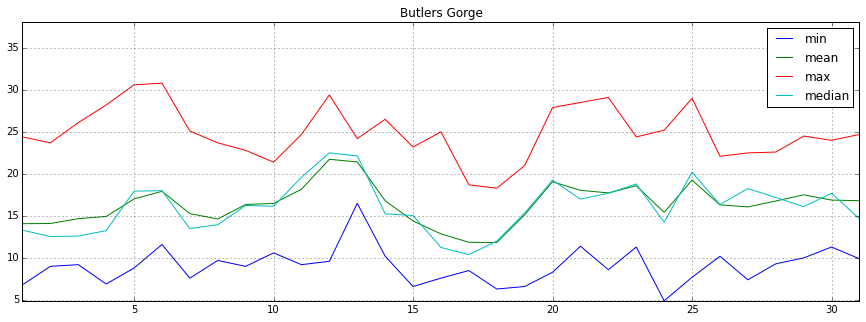

In [157]:
ybounds = (data[MAX_T_HEADING].min(), data[MAX_T_HEADING].max())

def get_station_name(k):
    for loc in LOCATIONS:
        if loc['stn_num'] == int(k):
            return loc['name']

for k in stations.groups.keys():
    d = stations.get_group(k)
    december = DataFrame()
    december['min'] = d.groupby(data[DATE_HEADING].dt.day)[MAX_T_HEADING].aggregate(min)
    december['mean'] = d.groupby(data[DATE_HEADING].dt.day)[MAX_T_HEADING].aggregate(np.mean)
    december['max'] = d.groupby(data[DATE_HEADING].dt.day)[MAX_T_HEADING].aggregate(max)
    december['median'] = d.groupby(data[DATE_HEADING].dt.day)[MAX_T_HEADING].aggregate(np.median)
    december.plot(figsize=(15,5),grid=True,title=get_station_name(k),ylim=ybounds)